In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# Function to generate random vector based on region
def generate_random_vector(x, y):
    # Define 8 possible vectors
    vectors = np.full(8, 0.5)  # Default probabilities of 0.5

    # Determine region based on (x, y)
    if x >= 0 and y >= 0 and y <= x:
        region = 0
    elif x >= 0 and y >= 0 and y > x:
        region = 1
    elif x <= 0 and y >= 0 and y >= -x:
        region = 2
    elif x <= 0 and y >= 0 and y < -x:
        region = 3
    elif x <= 0 and y <= 0 and y >= x:
        region = 4
    elif x <= 0 and y <= 0 and y < x:
        region = 5
    elif x >= 0 and y <= 0 and y <= -x:
        region = 6
    else:
        region = 7

    # Adjust the vector to have 0.7 probability in the determined region
    vectors[region] = 0.8
    
    # Randomly return 1 or 0 based on the probabilities in the vector
    return np.random.binomial(1, vectors)

# Example: Generate random vector for (x, y)
x, y = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
generated_vector = generate_random_vector(x, y)
x, y, generated_vector


(0.730333772832662, -0.1482333752220355, array([0, 0, 1, 1, 0, 1, 0, 1]))

In [3]:
# generate_random_vector for 10000 points
num_points = 100000
x = np.random.uniform(-1, 1, num_points)
y = np.random.uniform(-1, 1, num_points)
generated_vectors = np.array([generate_random_vector(x[i], y[i]) for i in range(num_points)])
train_features = np.array([x, y]).transpose()
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(generated_vectors, dtype=torch.float32)

In [4]:
# generate_random_vector for 100 points
num_points = 1000
x = np.random.uniform(-1, 1, num_points)
y = np.random.uniform(-1, 1, num_points)
generated_vectors = np.array([generate_random_vector(x[i], y[i]) for i in range(num_points)])
test_features = np.array([x, y]).transpose()
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(generated_vectors, dtype=torch.float32)

In [5]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

(torch.Size([100000, 2]),
 torch.Size([100000, 8]),
 torch.Size([1000, 2]),
 torch.Size([1000, 8]))

In [6]:
training_data = torch.utils.data.TensorDataset(train_features, train_labels)
test_data = torch.utils.data.TensorDataset(test_features, test_labels)
batch_size = 100
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"feature: {img}")
print(f"Label: {label}")

Feature batch shape: torch.Size([100, 2])
Labels batch shape: torch.Size([100, 8])
feature: tensor([ 0.1363, -0.0759])
Label: tensor([1., 1., 0., 1., 0., 0., 0., 1.])


In [10]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 8),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def custom_loss(output, target):
    # 出力ベクトルと正解ベクトルの内積
    loss = -torch.sum(output * target, dim=1)  # 内積
    return loss.mean()  # バッチ全体の平均をとる

model = NeuralNetwork().to(device)
print(model)

loss_fn = custom_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss =  0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {-test_loss:>8f} \n")
    

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=8, bias=True)
    (7): Softmax(dim=1)
  )
)


In [11]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: -0.524838 [  100/100000]
loss: -0.580530 [10100/100000]
loss: -0.743374 [20100/100000]
loss: -0.850917 [30100/100000]
loss: -0.729782 [40100/100000]
loss: -0.776994 [50100/100000]
loss: -0.799778 [60100/100000]
loss: -0.796772 [70100/100000]
loss: -0.768036 [80100/100000]
loss: -0.813632 [90100/100000]
Test Error: Avg loss: 0.792766 

Epoch 2
-------------------------------
loss: -0.724338 [  100/100000]
loss: -0.738217 [10100/100000]
loss: -0.795278 [20100/100000]
loss: -0.897248 [30100/100000]
loss: -0.755763 [40100/100000]
loss: -0.796597 [50100/100000]
loss: -0.814952 [60100/100000]
loss: -0.803615 [70100/100000]
loss: -0.782434 [80100/100000]
loss: -0.819067 [90100/100000]
Test Error: Avg loss: 0.801184 

Epoch 3
-------------------------------
loss: -0.730224 [  100/100000]
loss: -0.748437 [10100/100000]
loss: -0.799273 [20100/100000]
loss: -0.903658 [30100/100000]
loss: -0.763011 [40100/100000]
loss: -0.801331 [50100/100000]
loss: -0

In [14]:
model.eval()
test(test_dataloader, model, loss_fn)
print(f"One predictor: Avg loss: {0.8*1/8 + 0.5*7/8} \n")

Test Error: Avg loss: 0.810449 

One predictor: Avg loss: 0.5375 



In [15]:
# predict with test data
model.eval()
test_pred = model(test_features.to(device))
test_pred = test_pred.cpu().detach().numpy()

In [16]:
test_features_cpu = test_features.cpu().detach().numpy()
test_features_cpu[0], test_pred[0]

(array([-0.58749485, -0.90676856], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.4012985e-43,
        1.5727724e-13, 1.0000000e+00, 2.3708274e-23, 0.0000000e+00],
       dtype=float32))

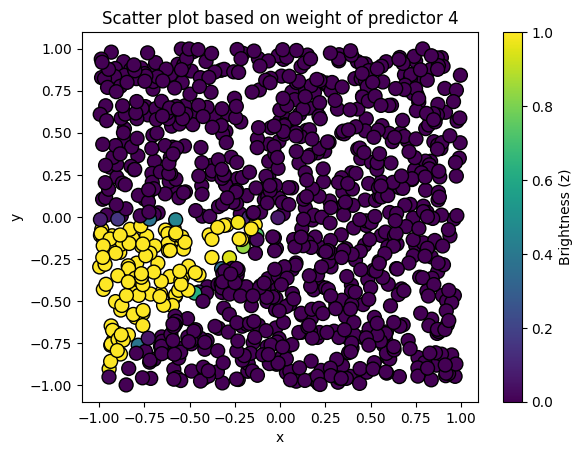

In [18]:
# plot the weight of a predictor
predictor = 4

plt.scatter(test_features_cpu[:, 0], test_features_cpu[:, 1], c=test_pred[:, predictor], cmap='viridis', s=100, edgecolor='black')

# Add labels and title
plt.title(f'Scatter plot based on weight of predictor {predictor}')
plt.xlabel('x')
plt.ylabel('y')

# Show colorbar to reflect the z brightness scale
plt.colorbar(label='Brightness (z)')

# Show plot
plt.show()